## Clusting/ Topic Modeling
This notebook will cluster and topic model on all of the characters in the set. Then will save the text associated with 

***
### Import packages 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# getting data 
import pymongo
import pandas as pd
from pymongo import MongoClient

# nltk 
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.util import ngrams
from nltk import bigrams, trigrams, word_tokenize

# sklearn 
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# gensim
from gensim import corpora, models, similarities, matutils
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# vis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS 

# other basics needed 
import re
import string
import random
import numpy as np
from collections import Counter, defaultdict
import pprint as pprint 

*** 
### Import data 

In [3]:
client = MongoClient()

In [34]:
db = client.starwars

movies = db.movies
movies_df = pd.DataFrame(list(movies.find()))
movies_df = movies_df.drop(columns = ['_id'])


character_names = ['Obi-Wan', 'Vader', 'Luke', 'C-3PO', 'Han', 'Padme', 'Yoda', 'Anakin', 'Leia']
characters_dict = {}

obi_wan = db.obi_wan
obi_wan_df = pd.DataFrame(list(obi_wan.find()))
obi_wan_df = obi_wan_df.drop(columns = ['_id'])
obi_wan_list = obi_wan_df['dialogue'].tolist()
characters_dict['Obi-Wan'] = obi_wan_list

vader = db.vader
vader_df = pd.DataFrame(list(vader.find()))
vader_df = vader_df.drop(columns = ['_id'])
vader_list = vader_df['dialogue'].tolist()
characters_dict['Vader'] = vader_list

luke = db.luke
luke_df = pd.DataFrame(list(luke.find()))
luke_df = luke_df.drop(columns = ['_id'])
luke_list = luke_df['dialogue'].tolist()
characters_dict['Luke'] = luke_list

c_3po = db.c_3po
c_3po_df = pd.DataFrame(list(c_3po.find()))
c_3po_df = c_3po_df.drop(columns = ['_id'])
c_3po_list = c_3po_df['dialogue'].tolist()
characters_dict['C-3PO'] = c_3po_list

han = db.han
han_df = pd.DataFrame(list(han.find()))
han_df = han_df.drop(columns = ['_id'])
han_list = han_df['dialogue'].tolist()
characters_dict['Han'] = han_list

padme = db.padme
padme_df = pd.DataFrame(list(padme.find()))
padme_df = padme_df.drop(columns = ['_id'])
padme_list = padme_df['dialogue'].tolist()
characters_dict['Padme'] = padme_list

yoda = db.yoda
yoda_df = pd.DataFrame(list(yoda.find()))
yoda_df = yoda_df.drop(columns = ['_id'])
yoda_list = yoda_df['dialogue'].tolist()
characters_dict['Yoda'] = yoda_list

anakin = db.anakin
anakin_df = pd.DataFrame(list(anakin.find()))
anakin_df = anakin_df.drop(columns = ['_id'])
anakin_list = anakin_df['dialogue'].tolist()
characters_dict['Anakin'] = anakin_list

leia = db.leia
leia_df = pd.DataFrame(list(leia.find()))
leia_df = leia_df.drop(columns = ['_id'])
leia_list = leia_df['dialogue'].tolist()
characters_dict['Leia'] = leia_list

# collection of all character databases
characters_df = [obi_wan_df, vader_df, luke_df, c_3po_df, han_df, padme_df, yoda_df, anakin_df, leia_df]

In [35]:
from pprint import pprint
pprint(characters_dict)

{'Anakin': ['Now...go, my son. Leave me.',
            'You already have, Luke. You were right about me. Tell your '
            'sister...you were right.',
            '(subtitled) Mel tassa cho-passa... (I was cleaning the bin like '
            'you...)',
            'Are you an angel?',
            "An angel. I've heard the deep space pilots talk about them. They "
            'live on the Moons of Iego I thimk. They are the most beautiful '
            'creatures in the universe. They are good and kind, and so pretty '
            'they make even the most hardened spice pirate cry.',
            "You must be one...maybe you just don't know it.",
            'Since I was very little, three, I think. My Mom and I were sold '
            'to Gardulla the Hutt, but she lost us, betting on the Podraces, '
            "to Watto, who's a lot better master than Gardulla, I think.",
            'I am a person! My name is Anakin.',
            'You are a strange girl to me.',
            "(

         "Let's get out of here. Ready for light-speed? One...two...three!",
         "It's not fair!",
         "The transfer circuits are working. It's not my fault!",
         "It's not my fault.",
         'Turn her around.',
         "I said turn her around! I'm going to put all power in the front  "
         'shield.',
         'The fleet is beginning to break up. Go back and stand  by the manual '
         'release for the landing claw.',
         'Thank you.',
         "Well, if they follow standard Imperial procedure, they'll dump  "
         'their garbage before they go to light-speed, then we just float '
         'away.',
         "Then we've got to find a safe port somewhere around here. Got any  "
         'ideas?',
         'The Anoat system.',
         'No. Well, wait. This is interesting. Lando.',
         "Lando's not a system, he's a man. Lando Calrissian. He's a card  "
         "player, gambler, scoundrel. You'd like him.",
         "Bespin. It's pretty far, but I

             'Then you must know Master Sido-Dyas?',
             'Sido-Dyas. Isn’t he the Jedi who hired you for this job?',
             'No? I thought...',
             'Curious...',
             "It seems to me it's your army - being that they are all clones "
             'of you.',
             'I look forward to seeing them in action. Thank you for your '
             'time, Jango.',
             "I won't forget.",
             '"Guiding light" to "old folks home."',
             '...Starships from the Trade Federation and the Commerce Guilds '
             'are taking deliveries of battle droids from the foundries on '
             'Geonosis.',
             'The droid foundry seems to be working at full capacity. I am '
             'going to go down and investigate. I will bring Jango Fett back '
             'home for interrogation.',
             'One more thing. Jango mentioned he was recruited by someone '
             'named Darth Tyranus. Any idea who that might be?',
  

*** 
### Cleaning text
cleaning text is the same for all models 

In [6]:
# dictionary of common contractions we will want to expand 
cList = {
  "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
  "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
  "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
  "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
  "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not",
  "it'd": "it had", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
  "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
  "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
  "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
  "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
  "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
  "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
  "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
  "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
  "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
  "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have",
  "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
  "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
  "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
  "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
  "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
  "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would",
  "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had",
  "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", "you're": "you are", "you've": "you have",
    "i'm" : "i am", "i'll" : "i will"
}

# function to expand contractions in text 
c_re = re.compile('(%s)' % '|'.join(cList.keys()))
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

# function to clean the text
stop_words = set(stopwords.words('english')) 
# add custom stop words 
def cleaning_function(corpus):
    cleaned_text = []
    for i in corpus: 
        clean_text = re.sub(r'\([^()]*\)', '', i)
        clean_text = clean_text.lower()
        clean_text = expandContractions(clean_text)
        # clean_text = re.sub('[%s]' % re.escape(string.punctuation),'', clean_text)
        # doc = [[word for word in text if word not in stop_words] for text in clean_text] 
    
        cleaned_text.append(clean_text)

    return cleaned_text

In [7]:
for character in character_names:
    clean_text = cleaning_function(characters_dict[character])
    characters_dict[character] = clean_text

In [8]:
pprint(characters_dict)

{'Anakin': ['now...go, my son. leave me.',
            'you already have, luke. you were right about me. tell your '
            'sister...you were right.',
            ' mel tassa cho-passa... ',
            'are you an angel?',
            "an angel. i've heard the deep space pilots talk about them. they "
            'live on the moons of iego i thimk. they are the most beautiful '
            'creatures in the universe. they are good and kind, and so pretty '
            'they make even the most hardened spice pirate cry.',
            'you must be one...maybe you just do not know it.',
            'since i was very little, three, i think. my mom and i were sold '
            'to gardulla the hutt, but she lost us, betting on the podraces, '
            'to watto, who is a lot better master than gardulla, i think.',
            'i am a person! my name is anakin.',
            'you are a strange girl to me.',
            ' hit the nose!',
            '...would not have lasted long i

            'how many back there. artoo?  three . . .  four . . . that is not '
            'good.',
            'i know. i know!',
            'i know. i know!',
            'i am going low and left.',
            'hang on, artoo. obi-wan, do you copy? i am going to pull them '
            'through the needle . . .',
            'sorry, no choice. come down here and thin them out a little.',
            'easy, artoo . . . we have done this before.',
            'wrong thought, artoo.',
            ' i am through.',
            'i am going to go help them out!',
            'missiles! pull up!',
            'they are coming around!',
            'surge all power units. artoo! stand by the reverse thrusters.',
            "we got 'em. artoo!",
            'i see them . . . buzz droids.',
            'move to the right so i can get a clear shot at them.',
            'steady . . . steady . . .',
            'i agree, bad idea. swing right . . . ease over . . . steady . . .',
            

          'what are you doing? you are not actually going into an asteroid  '
          'field?',
          'you do not have to do this to impress me.',
          'i take it back. we are going to get pulverized if we stay out  here '
          'much longer.',
          'closer?',
          'what looks pretty good?',
          'i hope you know what you are doing.',
          'let go.',
          'let go, please.',
          'captain, being held by you is not quite enough to get me excited.',
          'would you please stop calling me that?',
          'oh, you make it so difficult sometimes.',
          'occasionally  maybe...when you are not  acting like a scoundrel.',
          'stop that.',
          'stop that! my hands are dirty.',
          'afraid?',
          'i am not trembling.',
          'i happen to like nice men.',
          'no, you are not. you are...',
          'there is something out there.',
          'outside, in the cave.',
          'are you crazy?!',
          '

          'thought we were dead.',
          "do you really think we are going to find a pilot here that'll take "
          'us to alderaan?',
          'i am ready for anything.',
          'what?',
          'listen, why do not you wait out by the speeder.  we do not want any '
          'trouble.',
          'i am sorry.',
          'i will be careful than.',
          'ten thousand?  we could almost buy our own ship for that!',
          'you bet i could.  i am not such a bad pilot myself!  we do not have '
          'to sit here and listen...',
          'that is okay.  i am never coming back to this planet again.',
          'he says it is the best he can do.  since the xp-38 came out, they ',
          'what a piece of junk.',
          'why do not you outrun them?  i thought you said this thing was '
          'fast.',
          'are you kidding?  at the rate they are gaining...',
          'what is that flashing?',
          'are you all right?  what is wrong?',
          'yo

          'careful you must be when sensing the future, anakin. the fear of '
          'loss is a path to the dark side.',
          'death is a natural part of life. rejoice for those around you who '
          'transform into the force. mourn them, do not. miss them, do not. '
          'attachment leads to jealousy. the shadow of greed, that is.',
          'train yourself to let go of everything you fear to lose.',
          'allow this appointment lightly, the council does not. disturbing is '
          'this move by chancellor palpatine.',
          'hiding in the outer rim, grievous is. the outlying systems, you '
          'must sweep.',
          'master kenobi, our spies contact, you must, and then wait.',
          'go, i will. good relations with the wookiees, i have.',
          'too much under the sway of the chancellor, he is. much anger there '
          'is in him. too much pride in his powers.',
          'a prophecy . . . that misread could have been.',
          'i

In [9]:
# here I define a tokenizer and lemmatizer which returns the set of stems in the text that it is passed
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def tokenize_and_lem(text):
    lemmatized = []
    for i in text:
        # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
        tokens = [word for sent in nltk.sent_tokenize(i) for word in nltk.word_tokenize(sent)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        #lems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
        lemmatized_output = ' '.join([lemmatizer.lemmatize(t) for t in filtered_tokens])
        lemmatized.append(lemmatized_output)
    return lemmatized

In [10]:
for character in character_names:
    clean_text = tokenize_and_lem(characters_dict[character])
    characters_dict[character] = clean_text

In [11]:
pprint(characters_dict)

{'Anakin': ['now go my son leave me',
            'you already have luke you were right about me tell your sister '
            'you were right',
            'mel tassa cho-passa',
            'are you an angel',
            "an angel i 've heard the deep space pilot talk about them they "
            'live on the moon of iego i thimk they are the most beautiful '
            'creature in the universe they are good and kind and so pretty '
            'they make even the most hardened spice pirate cry',
            'you must be one maybe you just do not know it',
            'since i wa very little three i think my mom and i were sold to '
            'gardulla the hutt but she lost u betting on the podraces to watto '
            'who is a lot better master than gardulla i think',
            'i am a person my name is anakin',
            'you are a strange girl to me',
            'hit the nose',
            'would not have lasted long if i were not so good at fixing thing '
        

          'that is right artoo we are going to the dagobah system i have a '
          'promise to keep to an old friend',
          'no of course not',
          'master yoda you can not die',
          "but i need your help i 've come back to complete the training",
          'then i am a jedi',
          'master yoda is darth vader my father',
          'yoda i must know',
          'yes',
          'unfortunate that i know the truth',
          'well i am sorry',
          'i can not do it artoo i can not go on alone',
          'obi-wan why did not you tell me',
          'you told me vader betrayed and murdered my father',
          'a certain point of view',
          'there is still good in him',
          'i can not do it ben',
          'i tried to stop him once i could not do it',
          'but i had to help my friend',
          'i found out darth vader wa my father',
          'i can not kill my own father',
          'yoda spoke of another',
          'but i have no sist

***
### TF-IDF & KMeans clusters
- use tf-idf to vectorize
- use clustering for topics 
- via sklearn 

In [21]:
def tfidf_kmeans(text, character):
    print('\n\n')
    print('-------------------------------------- TF-IDF with kmean clusters for ' + character + ' ----------------------------------------------' )
    
    # define and fit vectorizer to the text
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=20000, min_df=0.05, stop_words=stop_words, ngram_range=(1,2))
    tfidf_matrix = tfidf_vectorizer.fit_transform(text) 
    #tokenizer=tokenize_and_lem,
    #print('tfidf matrix shape' + tfidf_matrix.shape)
    
    terms = tfidf_vectorizer.get_feature_names()
    
    # define and fit clusters with the vectorizer matrix 
    num_clusters = 4
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    
    all_text = {'text': text,  'cluster': clusters}
    frame = pd.DataFrame(all_text, index = [clusters] , columns = ['text', 'cluster'])
    
    
    print("Top terms per cluster:")
    print()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    for i in range(num_clusters):
        print('Cluster %d:' % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind]),
        print
        
        
        print("Cluster %d text:" % i, end='')
        for title in frame.ix[i]['text'].values.tolist():
            print(' %s,' % title, end='')
        print('\n')
        
    plt.bar(range(0,num_clusters), [frame['cluster'].value_counts()[i] for i in range(0, num_clusters)], align='center', alpha=0.5)
    plt.ylabel('Number of texts')
    plt.xlabel('Topic Number')
    plt.title('Number of texts in each Topic')
    plt.show()




-------------------------------------- TF-IDF with kmean clusters for Obi-Wan ----------------------------------------------
Top terms per cluster:

Cluster 0:
 wa
 master
 anakin
Cluster 0 text: hello there come here my little friend do not be afraid, do not worry he will be all right, rest easy son you have had a busy day you are fortunate you are still in one piece, the jundland waste are not to be traveled lightly tell me young luke what brings you out this far, obi-wan kenobi obi-wan now thats a name i have not heard in a long time a long time, oh he is not dead no not yet, well of course of course i know him he is me i have not gone by the name obi-wan since oh before you were born, do not seem to remember ever owning a droid very interesting, i think we better get indoors the sand people are easily startled but they will soon be back and in greater number, quickly son they are on the move, that is what your uncle told you he did not hold with your father 's ideal thought he s

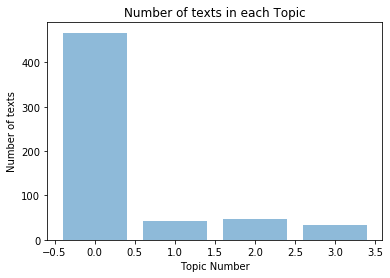




-------------------------------------- TF-IDF with kmean clusters for Vader ----------------------------------------------
Top terms per cluster:

Cluster 0:
 emperor
 rebel
 ha
 force
 wan
 ship
 obi wan
 obi
 master
Cluster 0 text: where are those transmission you intercepted, you are a part of the rebel alliance and a traitor take her away, i have traced the rebel spy to her now she is my only link to find their secret base, leave that to me send a distress signal and then inform the senate that all aboard were killed, she must have hidden the plan in the escape pod send a detachment down to retrieve them see to it personally commander there 'll be no one to stop u this time, the plan you refer to will soon be back in our hand, do not be too proud of this technological terror you have constructed the ability to destroy a planet is insignificant next to the power of the force, i find your lack of faith disturbing, a you wish, and now your highness we will discus the location of yo

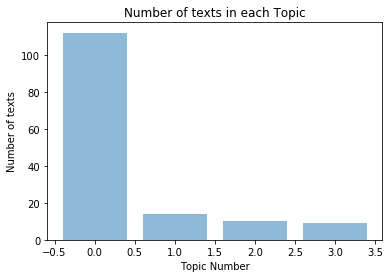




-------------------------------------- TF-IDF with kmean clusters for Luke ----------------------------------------------
Top terms per cluster:

Cluster 0:
 get
 come
 right
 know
 going
Cluster 0 text: hurry up come with me what are you waiting for get in gear, shape it up you guy biggs, the academy did not change you much but you are back so soon hey what happened did not you get your commission, there they are, but there wa a lot of firing earlier, hey easy with those, look who is talking now that you have been around those giant starship you are beginning to sound like my uncle you have gotten soft in the city, well thing have not been the same since you left biggs it is been so quiet, what are you talking about, join the rebellion are you kidding how, i am sorry i am quiet listen how quiet i am you can barely hear me, around forever trying to find them, and i am stuck here, not likely i had to cancel my application there ha been a lot of unrest among the sand people since you 

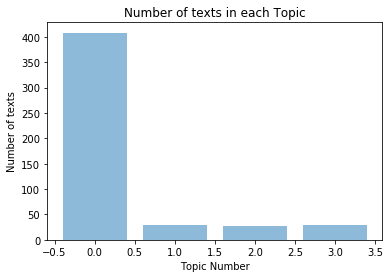




-------------------------------------- TF-IDF with kmean clusters for C-3PO ----------------------------------------------
Top terms per cluster:

Cluster 0:
 oh
 master
 see
 master luke
 luke
 well
 say
 think
 artoo
 sir
Cluster 0 text: oh my i 'd forgotten how much i hate space travel, oh no, oh all this excitement ha overrun the circuit of my counterpart here if you do not mind i 'd like to take him down to maintenance, use the comlink oh my i forgot i turned it off, oh switch off, actually artoo ha been known to make mistake from time to time oh dear oh dear do not worry about master luke i am sure he will be all right he is quite clever you know for a human being, artoo you take good care of master luke now understand and do take care of yourself oh dear oh dear, oh wait for me, oh this is suicide, oh sometimes i just do not understand human behavior after all i am only trying to do my job in the most, i think it might be better if i stay here and guard the ship oh no, oh tha

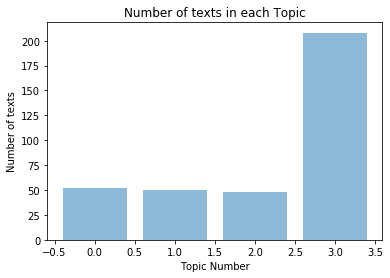




-------------------------------------- TF-IDF with kmean clusters for Han ----------------------------------------------
Top terms per cluster:

Cluster 0:
 well
 got
 come
 right
 going
 get
 chewie
Cluster 0 text: fast ship you have never heard of the millennium falcon, it is the ship that made the kessel run in le than twelve parsec, i 've outrun imperial starship not the local bulk-cruisers mind you i am talking about the big corellian ship now she is fast enough for you old man what is the cargo, what is it some kind of local trouble, seventeen huh, okay you guy got yourself a ship we will leave a soon a you are ready docking bay ninety-four, look like somebody 's beginning to take an interest in your handiwork, yeah but this time i got the money, i do not have it with me tell jabba, over my dead body, yes i will bet you have, sorry about the mess, i 've been waiting for you jabba, i am not the type to run, you sent greedo to blast me, i think he thought he wa next time do not 

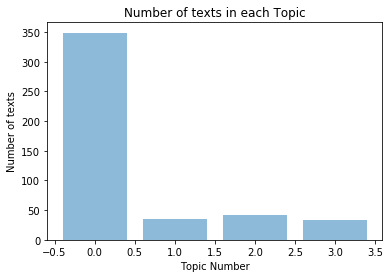




-------------------------------------- TF-IDF with kmean clusters for Padme ----------------------------------------------
Top terms per cluster:

Cluster 0:
 jedi
 know
 annie
 wa
 anakin
Cluster 0 text: we are brave your highness, that is all right, thank you this little guy is quite a mess, i am padme i attend her highness you are a gungan are not you how did you end up here with u, i 've been trained in defense i can take care of myself, .like u jar jar is in a constant state of panic, what, i 've never heard of angel, you are a funny little boy how do you know so much, you are a slave, i am sorry i do not fully understand this is a strange world to me, i am glad i met you .ah, padme naberrie, and that work for you, on the outskirt, and our droid artoo-detoo, he is wonderful, he is perfect, i can not believe there is still slavery in the galaxy the republic 's anti-slavery law, these junk dealer must have a weakness of some kind, i am sure qui-gon doe not want to put your son in

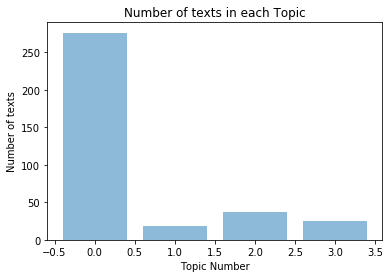




-------------------------------------- TF-IDF with kmean clusters for Yoda ----------------------------------------------
Top terms per cluster:

Cluster 0:
 dark
 side
 dark side
 force
 see
 must
 jedi
 yes
 one
 master
Cluster 0 text: run yes a jedi 's strength flow from the force but beware of the dark side anger fear aggression the dark side of the force are they easily they flow quick to join you in a fight if once you start down the dark path forever will it dominate your destiny consume you it will a it did obi-wan 's apprentice, that place is strong with the dark side of the force a domain of evil it is in you must go, remember a jedi 's strength flow from the force but beware anger fear aggression the dark side are they once you start down the dark path forever will it dominate your destiny, hard to see the dark side is discover who this assassin is we must, eveything fear is the path to the dark side fear lead to anger anger lead to hate.. hate lead to suffering, impossib

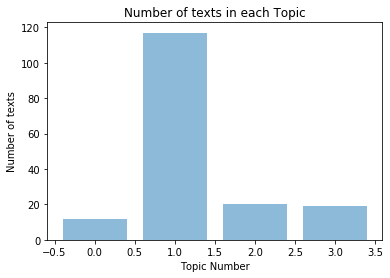




-------------------------------------- TF-IDF with kmean clusters for Anakin ----------------------------------------------
Top terms per cluster:

Cluster 0:
 going
 master
 know
 jedi
Cluster 0 text: now go my son leave me, you already have luke you were right about me tell your sister you were right, mel tassa cho-passa, are you an angel, an angel i 've heard the deep space pilot talk about them they live on the moon of iego i thimk they are the most beautiful creature in the universe they are good and kind and so pretty they make even the most hardened spice pirate cry, i am a person my name is anakin, you are a strange girl to me, hit the nose, would not have lasted long if i were not so good at fixing thing i am making my own droid, anakin, anakin skywalker, i am glad i met you too, la lova num botaffa, because you are afraid, chess ko sebulba coo wolpa tooney rana, oh da hutt cha porko ootman geesa me teesa rodda co pana pee choppa chawa, eh chee bana do mullee ra, hi your bu

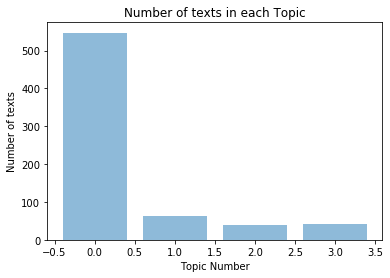




-------------------------------------- TF-IDF with kmean clusters for Leia ----------------------------------------------
Top terms per cluster:

Cluster 0:
 luke
 get
 know
Cluster 0 text: luke, luke luke grab a hold of this, come on luke it too late, luke luke luke, then it could not be one of those creature that attacked luke, luke luke do not it is a trap it is a trap, luke we have got to go back, i know where luke is, it is luke chewie slow down slow down and we will get under him lando open the top hatch, luke tell me what is troubling you, luke do not talk that way you have a power i i do not understand and could never have, no luke run away far away if he can feel your presence then leave this place i wish i could go with you,

Cluster 1:
 luke
 know
 get
Cluster 1 text: lord vader i should have known only you could be so bold the imperial senate will not sit stillfor this when they hear you have attacked a diplomatic, help me obi-wan kenobi you aremy only hope, help me obi-

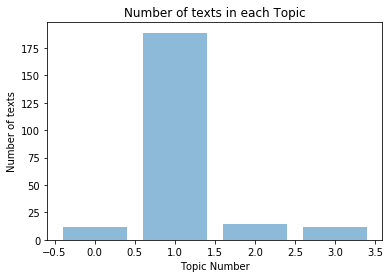

In [22]:
for character in character_names:
    tfidf_kmeans(characters_dict[character], character)

*** 
### CV & LDA
- use count vectorizer 
- use LDA for topics 
- via gensim

In [14]:
def cv_lda_gensim(text, character):
    print('\n\n')
    print('-------------------------------------- CV and LDA topics for ' + character + ' ----------------------------------------------' )
    
    count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words) #, token_pattern="\\b[a-z][a-z]+\\b")
    # max_df=0.9, min_df=0.05,
    count_vectorizer.fit(text)
    
    doc_word = count_vectorizer.transform(text).transpose()
    corpus = matutils.Sparse2Corpus(doc_word)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=5)
    
    topic_matrix = lda.show_topics(formatted=False, num_words=5)
    print('\n Top 5 words in topics')
    pprint(topic_matrix)
    
    topics_matrix = lda.show_topics(formatted=False, num_words=10)
    for i in range(0,len(topics_matrix)):
        words = []
        values = []
        for k in range(0,10):
            words.append(topics_matrix[i][1][k][0])
            values.append(topics_matrix[i][1][k][1])
        plt.bar(words, values, alpha=0.5)
        plt.ylabel('Weight')
        plt.xlabel('Word')
        plt.title('Top 10 words in Topic '+str(i))
        plt.show()
        print(words)




-------------------------------------- CV and LDA topics for Obi-Wan ----------------------------------------------

 Top 5 words in topics
[(0,
  [('anakin', 0.016684262),
   ('council', 0.006978579),
   ('must', 0.0065813614),
   ('let', 0.005851176),
   ('chancellor', 0.0057661044)]),
 (1,
  [('wa', 0.011028599),
   ('anakin', 0.0065911924),
   ('father', 0.0054624453),
   ('ha', 0.0048139514),
   ('force', 0.0043633603)]),
 (2,
  [('time', 0.009440439),
   ('master', 0.0071965866),
   ('wa', 0.006084513),
   ('ha', 0.0054075364),
   ('think', 0.0048678736)]),
 (3,
  [('jedi', 0.010122552),
   ('get', 0.007523256),
   ('master', 0.00498837),
   ('ship', 0.00393049),
   ('ha', 0.0039182217)]),
 (4,
  [('master', 0.0069601336),
   ('anakin', 0.0052787047),
   ('going', 0.004801537),
   ('take', 0.0047778245),
   ('luke', 0.004773917)])]


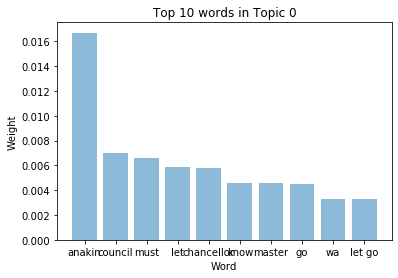

['anakin', 'council', 'must', 'let', 'chancellor', 'know', 'master', 'go', 'wa', 'let go']


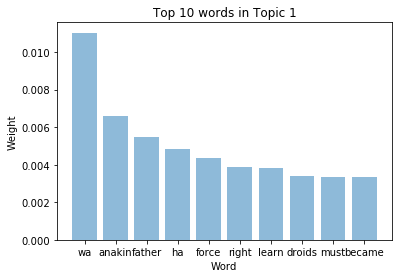

['wa', 'anakin', 'father', 'ha', 'force', 'right', 'learn', 'droids', 'must', 'became']


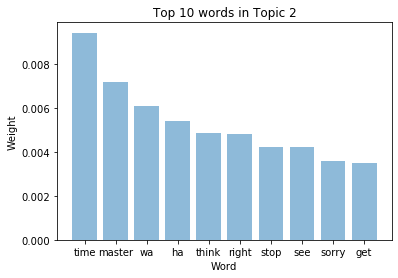

['time', 'master', 'wa', 'ha', 'think', 'right', 'stop', 'see', 'sorry', 'get']


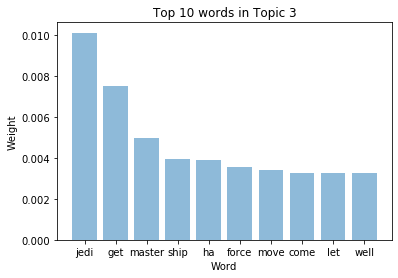

['jedi', 'get', 'master', 'ship', 'ha', 'force', 'move', 'come', 'let', 'well']


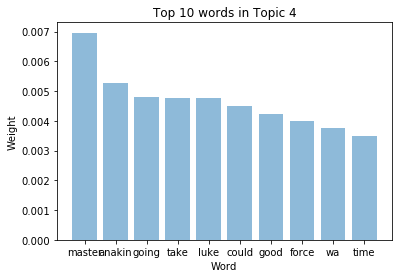

['master', 'anakin', 'going', 'take', 'luke', 'could', 'good', 'force', 'wa', 'time']



-------------------------------------- CV and LDA topics for Vader ----------------------------------------------

 Top 5 words in topics
[(0,
  [('commander', 0.011544301),
   ('ship', 0.0074050953),
   ('bring', 0.0060504414),
   ('emperor', 0.0060470435),
   ('perhaps', 0.0060433378)]),
 (1,
  [('ha', 0.015908934),
   ('yes', 0.015686607),
   ('yes master', 0.009781103),
   ('master', 0.009781023),
   ('admiral', 0.009725372)]),
 (2,
  [('wa', 0.007540352),
   ('skywalker', 0.00708804),
   ('system', 0.0069467984),
   ('master', 0.0055263327),
   ('wan', 0.005513444)]),
 (3,
  [('master', 0.013828402),
   ('force', 0.009956942),
   ('rebel', 0.00991309),
   ('emperor', 0.008066441),
   ('captain', 0.0062319776)]),
 (4,
  [('want', 0.009621871),
   ('ship', 0.009496704),
   ('asteroid', 0.007177097),
   ('destiny', 0.0071391226),
   ('luke', 0.0050310167)])]


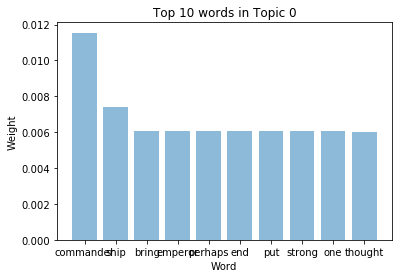

['commander', 'ship', 'bring', 'emperor', 'perhaps', 'end', 'put', 'strong', 'one', 'thought']


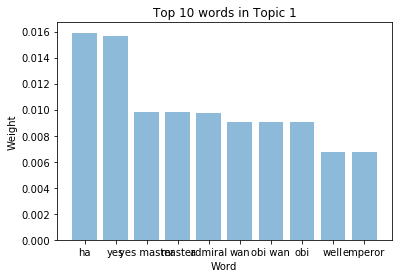

['ha', 'yes', 'yes master', 'master', 'admiral', 'wan', 'obi wan', 'obi', 'well', 'emperor']


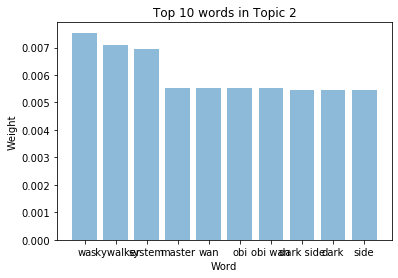

['wa', 'skywalker', 'system', 'master', 'wan', 'obi', 'obi wan', 'dark side', 'dark', 'side']


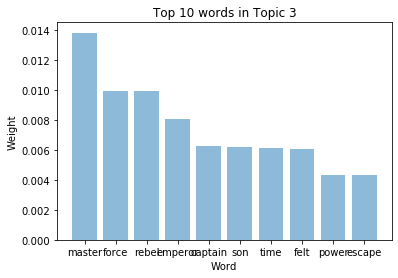

['master', 'force', 'rebel', 'emperor', 'captain', 'son', 'time', 'felt', 'power', 'escape']


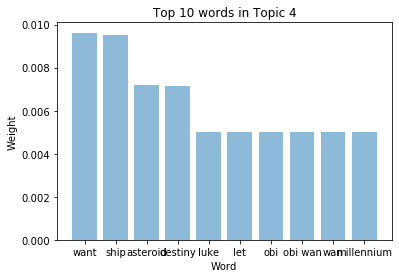

['want', 'ship', 'asteroid', 'destiny', 'luke', 'let', 'obi', 'obi wan', 'wan', 'millennium']



-------------------------------------- CV and LDA topics for Luke ----------------------------------------------

 Top 5 words in topics
[(0,
  [('father', 0.011131799),
   ('back', 0.0107241105),
   ('going', 0.0069606435),
   ('look', 0.006774331),
   ('come', 0.005947196)]),
 (1,
  [('artoo', 0.00958542),
   ('see', 0.0091276225),
   ('oh', 0.008694431),
   ('going', 0.007095645),
   ('father', 0.006559822)]),
 (2,
  [('know', 0.01388307),
   ('right', 0.012390606),
   ('threepio', 0.01063727),
   ('well', 0.0074899453),
   ('han', 0.0074327686)]),
 (3,
  [('ben', 0.017046262),
   ('get', 0.0071043614),
   ('got', 0.005546628),
   ('good', 0.0052618766),
   ('put', 0.0052078385)]),
 (4,
  [('going', 0.010496555),
   ('go', 0.008869266),
   ('get', 0.008831809),
   ('come', 0.008652651),
   ('got', 0.0071698143)])]


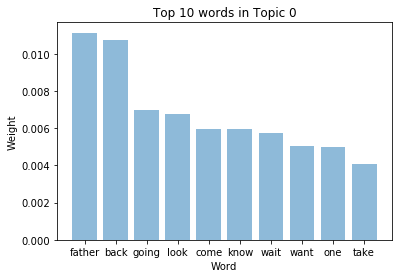

['father', 'back', 'going', 'look', 'come', 'know', 'wait', 'want', 'one', 'take']


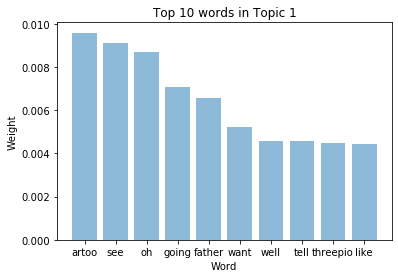

['artoo', 'see', 'oh', 'going', 'father', 'want', 'well', 'tell', 'threepio', 'like']


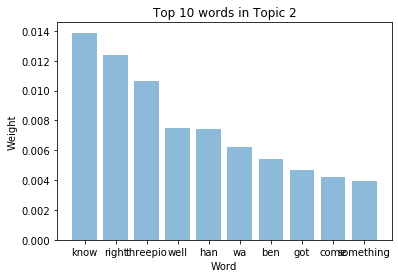

['know', 'right', 'threepio', 'well', 'han', 'wa', 'ben', 'got', 'come', 'something']


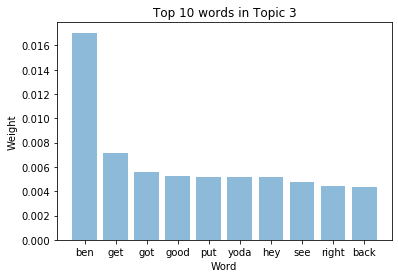

['ben', 'get', 'got', 'good', 'put', 'yoda', 'hey', 'see', 'right', 'back']


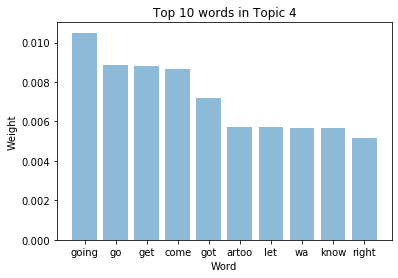

['going', 'go', 'get', 'come', 'got', 'artoo', 'let', 'wa', 'know', 'right']



-------------------------------------- CV and LDA topics for C-3PO ----------------------------------------------

 Top 5 words in topics
[(0,
  [('oh', 0.020303594),
   ('sir', 0.014667848),
   ('master', 0.013905506),
   ('master luke', 0.009584811),
   ('luke', 0.009575526)]),
 (1,
  [('oh', 0.019803109),
   ('sir', 0.0072117387),
   ('thank', 0.0069722314),
   ('oh oh', 0.005242317),
   ('could', 0.0051522385)]),
 (2,
  [('artoo', 0.010188118),
   ('oh', 0.009196363),
   ('sir', 0.006553395),
   ('would', 0.005494043),
   ('know', 0.0046898136)]),
 (3,
  [('artoo', 0.021441083),
   ('sir', 0.007684809),
   ('see', 0.007667294),
   ('master', 0.0070339176),
   ('come', 0.0068559996)]),
 (4,
  [('oh', 0.014403195),
   ('sir', 0.008273354),
   ('artoo', 0.0073175025),
   ('wait', 0.0072150826),
   ('going', 0.0063785524)])]


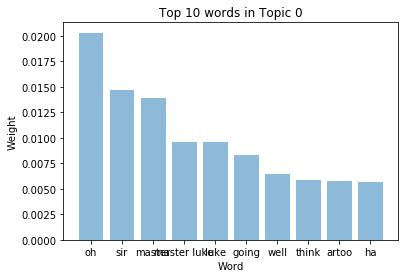

['oh', 'sir', 'master', 'master luke', 'luke', 'going', 'well', 'think', 'artoo', 'ha']


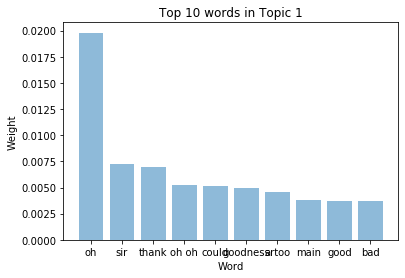

['oh', 'sir', 'thank', 'oh oh', 'could', 'goodness', 'artoo', 'main', 'good', 'bad']


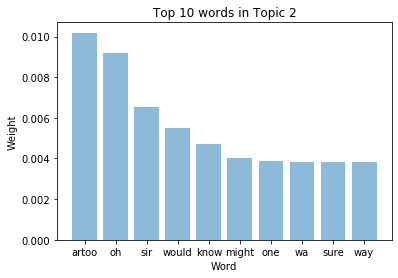

['artoo', 'oh', 'sir', 'would', 'know', 'might', 'one', 'wa', 'sure', 'way']


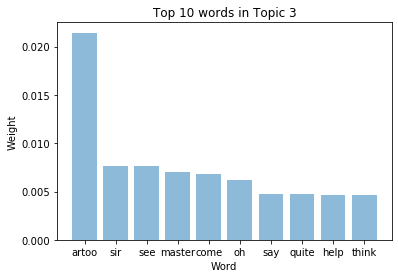

['artoo', 'sir', 'see', 'master', 'come', 'oh', 'say', 'quite', 'help', 'think']


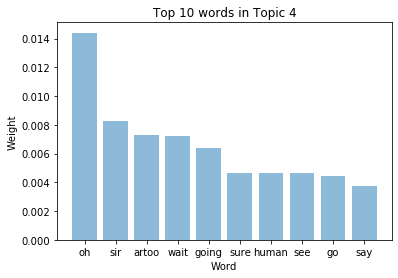

['oh', 'sir', 'artoo', 'wait', 'going', 'sure', 'human', 'see', 'go', 'say']



-------------------------------------- CV and LDA topics for Han ----------------------------------------------

 Top 5 words in topics
[(0,
  [('luke', 0.013815917),
   ('get', 0.009860265),
   ('lando', 0.00916039),
   ('chewie', 0.008797789),
   ('hey', 0.00802101)]),
 (1,
  [('one', 0.008772071),
   ('good', 0.008004636),
   ('get', 0.0077568125),
   ('like', 0.007294705),
   ('come', 0.0056884745)]),
 (2,
  [('kid', 0.0071313973),
   ('going', 0.0054571433),
   ('better', 0.0052545466),
   ('bad', 0.0045231567),
   ('chewie', 0.0037077689)]),
 (3,
  [('chewie', 0.017327728),
   ('get', 0.01363952),
   ('going', 0.01083155),
   ('right', 0.008782265),
   ('well', 0.006864326)]),
 (4,
  [('come', 0.012062336),
   ('get', 0.0072209295),
   ('got', 0.006318682),
   ('right', 0.00631532),
   ('look', 0.0048534973)])]


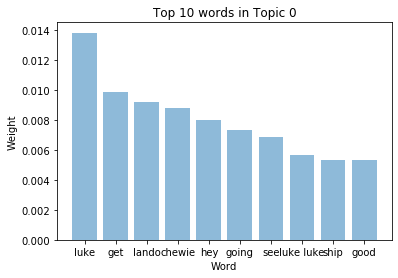

['luke', 'get', 'lando', 'chewie', 'hey', 'going', 'see', 'luke luke', 'ship', 'good']


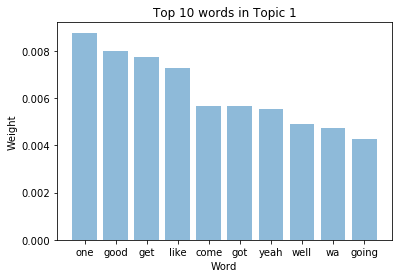

['one', 'good', 'get', 'like', 'come', 'got', 'yeah', 'well', 'wa', 'going']


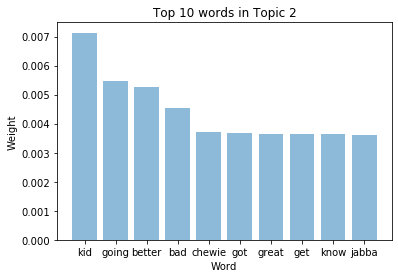

['kid', 'going', 'better', 'bad', 'chewie', 'got', 'great', 'get', 'know', 'jabba']


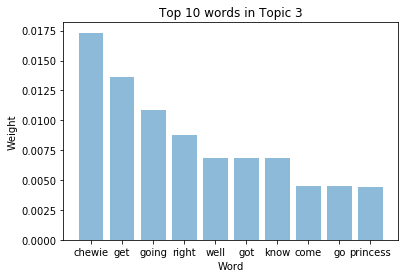

['chewie', 'get', 'going', 'right', 'well', 'got', 'know', 'come', 'go', 'princess']


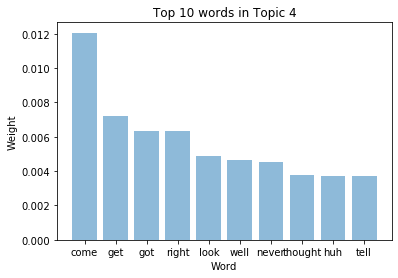

['come', 'get', 'got', 'right', 'look', 'well', 'never', 'thought', 'huh', 'tell']



-------------------------------------- CV and LDA topics for Padme ----------------------------------------------

 Top 5 words in topics
[(0,
  [('wa', 0.008809674),
   ('annie', 0.008167181),
   ('war', 0.0072995876),
   ('let', 0.004957461),
   ('sure', 0.0049485033)]),
 (1,
  [('know', 0.010090468),
   ('could', 0.0091077015),
   ('anakin', 0.005990642),
   ('nothing', 0.0048155943),
   ('ha', 0.004663536)]),
 (2,
  [('jedi', 0.00837457),
   ('anakin', 0.00566876),
   ('ha', 0.0056528556),
   ('love', 0.0055496204),
   ('help', 0.005518024)]),
 (3,
  [('anakin', 0.018450974),
   ('wa', 0.0056980173),
   ('guess', 0.0051811845),
   ('would', 0.004412797),
   ('right', 0.0040791268)]),
 (4,
  [('wa', 0.016522812),
   ('wan', 0.008192925),
   ('obi wan', 0.00818794),
   ('obi', 0.008185002),
   ('jedi', 0.006407815)])]


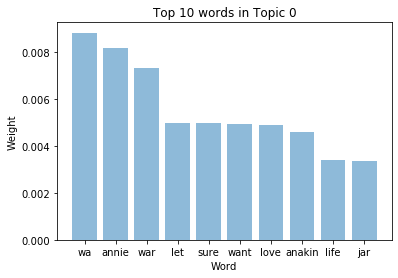

['wa', 'annie', 'war', 'let', 'sure', 'want', 'love', 'anakin', 'life', 'jar']


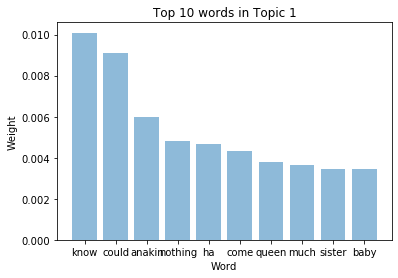

['know', 'could', 'anakin', 'nothing', 'ha', 'come', 'queen', 'much', 'sister', 'baby']


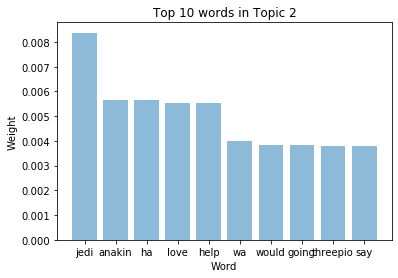

['jedi', 'anakin', 'ha', 'love', 'help', 'wa', 'would', 'going', 'threepio', 'say']


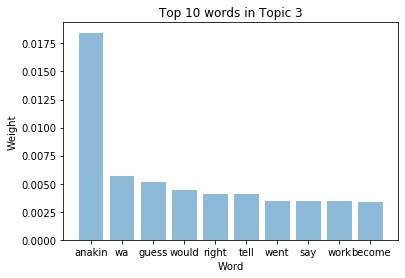

['anakin', 'wa', 'guess', 'would', 'right', 'tell', 'went', 'say', 'work', 'become']


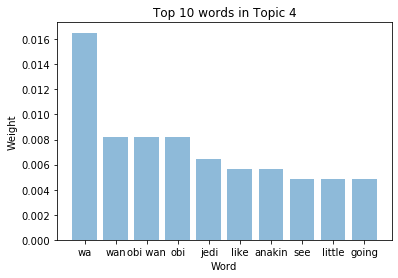

['wa', 'wan', 'obi wan', 'obi', 'jedi', 'like', 'anakin', 'see', 'little', 'going']



-------------------------------------- CV and LDA topics for Yoda ----------------------------------------------

 Top 5 words in topics
[(0,
  [('luke', 0.009318151),
   ('jedi', 0.009101147),
   ('force', 0.006432287),
   ('agree', 0.0056671705),
   ('see', 0.0055407747)]),
 (1,
  [('dark', 0.020026077),
   ('force', 0.01561013),
   ('dark side', 0.014638355),
   ('side', 0.014552199),
   ('must', 0.00824285)]),
 (2,
  [('force', 0.01367082),
   ('jedi', 0.009941263),
   ('one', 0.008757186),
   ('must', 0.0085636955),
   ('good', 0.0074967262)]),
 (3,
  [('must', 0.02037999),
   ('yes', 0.009552091),
   ('master', 0.0064402004),
   ('control', 0.0049377847),
   ('war', 0.004930832)]),
 (4,
  [('much', 0.013583958),
   ('say', 0.007002015),
   ('master', 0.0053863986),
   ('qui gon', 0.0053783115),
   ('gon', 0.0053690905)])]


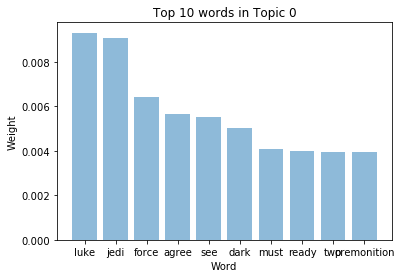

['luke', 'jedi', 'force', 'agree', 'see', 'dark', 'must', 'ready', 'two', 'premonition']


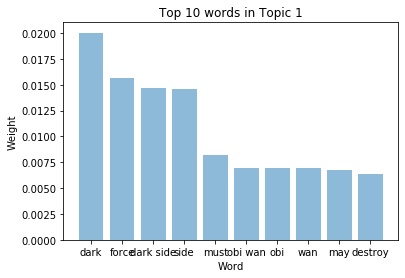

['dark', 'force', 'dark side', 'side', 'must', 'obi wan', 'obi', 'wan', 'may', 'destroy']


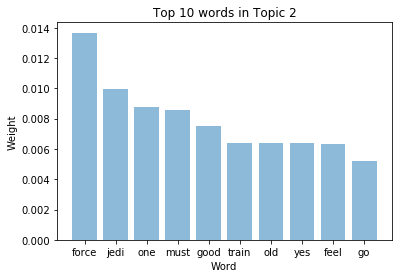

['force', 'jedi', 'one', 'must', 'good', 'train', 'old', 'yes', 'feel', 'go']


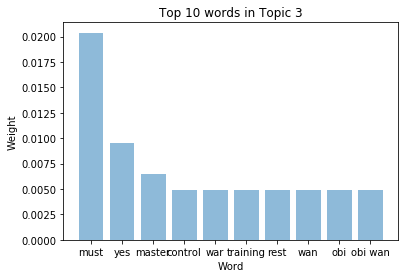

['must', 'yes', 'master', 'control', 'war', 'training', 'rest', 'wan', 'obi', 'obi wan']


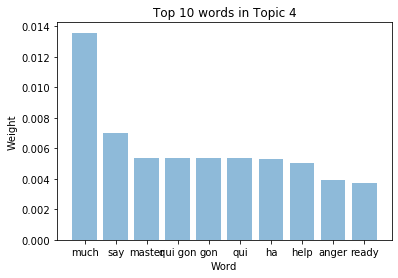

['much', 'say', 'master', 'qui gon', 'gon', 'qui', 'ha', 'help', 'anger', 'ready']



-------------------------------------- CV and LDA topics for Anakin ----------------------------------------------

 Top 5 words in topics
[(0,
  [('know', 0.015874814),
   ('padme', 0.007920955),
   ('help', 0.0053710276),
   ('right', 0.0053706197),
   ('obi wan', 0.004098559)]),
 (1,
  [('right', 0.010300346),
   ('wa', 0.008678417),
   ('mom', 0.008564774),
   ('think', 0.006492867),
   ('way', 0.006014484)]),
 (2,
  [('master', 0.017994907),
   ('going', 0.0122828595),
   ('sorry', 0.0064132623),
   ('like', 0.006387536),
   ('one', 0.0052566533)]),
 (3,
  [('jedi', 0.014613521),
   ('master', 0.012342146),
   ('want', 0.006690003),
   ('go', 0.006241546),
   ('mean', 0.0050917473)]),
 (4,
  [('yes', 0.013411199),
   ('artoo', 0.01006418),
   ('master', 0.00886306),
   ('get', 0.0074485517),
   ('mom', 0.006485673)])]


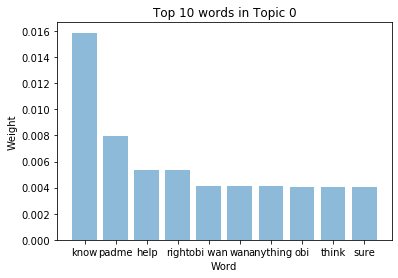

['know', 'padme', 'help', 'right', 'obi wan', 'wan', 'anything', 'obi', 'think', 'sure']


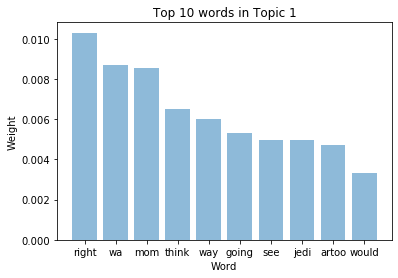

['right', 'wa', 'mom', 'think', 'way', 'going', 'see', 'jedi', 'artoo', 'would']


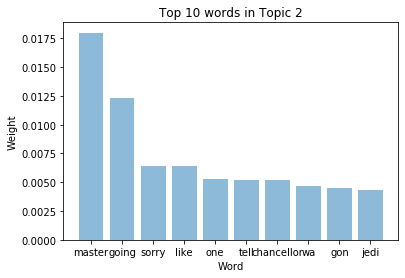

['master', 'going', 'sorry', 'like', 'one', 'tell', 'chancellor', 'wa', 'gon', 'jedi']


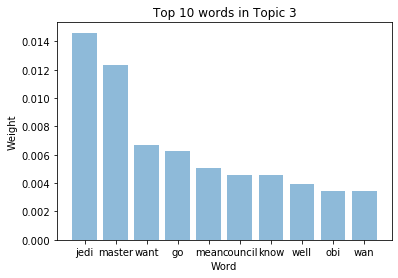

['jedi', 'master', 'want', 'go', 'mean', 'council', 'know', 'well', 'obi', 'wan']


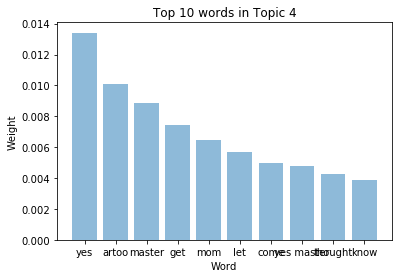

['yes', 'artoo', 'master', 'get', 'mom', 'let', 'come', 'yes master', 'thought', 'know']



-------------------------------------- CV and LDA topics for Leia ----------------------------------------------

 Top 5 words in topics
[(0,
  [('get', 0.013817758),
   ('chewie', 0.009212994),
   ('oh', 0.008913353),
   ('know', 0.007075153),
   ('got', 0.007035176)]),
 (1,
  [('know', 0.008124709),
   ('got', 0.008073801),
   ('need', 0.008071708),
   ('lando', 0.0080657005),
   ('hurt', 0.0071998932)]),
 (2,
  [('come', 0.012471106),
   ('wa', 0.007870906),
   ('right', 0.0077078175),
   ('like', 0.007662632),
   ('little', 0.0054391255)]),
 (3,
  [('know', 0.012023259),
   ('han', 0.009186321),
   ('get', 0.0077379732),
   ('luke', 0.0063327258),
   ('going', 0.006238655)]),
 (4,
  [('luke', 0.012458318),
   ('help', 0.010998183),
   ('kenobi', 0.009449782),
   ('wan kenobi', 0.007963335),
   ('obi wan', 0.0079614455)])]


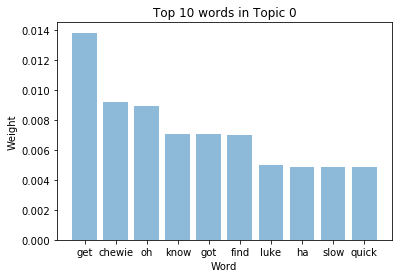

['get', 'chewie', 'oh', 'know', 'got', 'find', 'luke', 'ha', 'slow', 'quick']


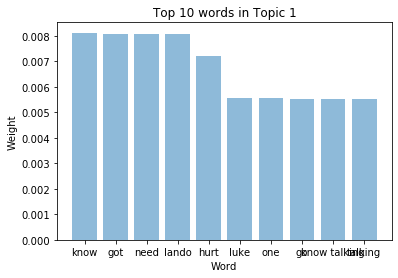

['know', 'got', 'need', 'lando', 'hurt', 'luke', 'one', 'go', 'know talking', 'talking']


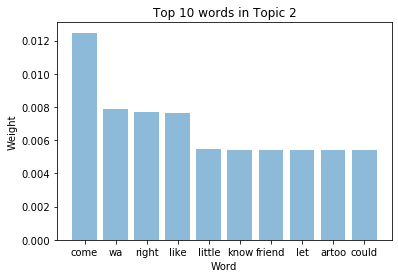

['come', 'wa', 'right', 'like', 'little', 'know', 'friend', 'let', 'artoo', 'could']


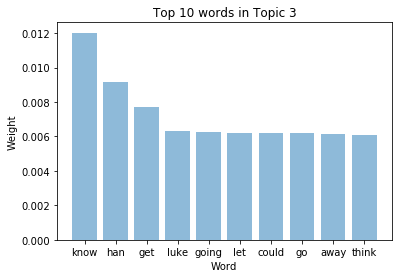

['know', 'han', 'get', 'luke', 'going', 'let', 'could', 'go', 'away', 'think']


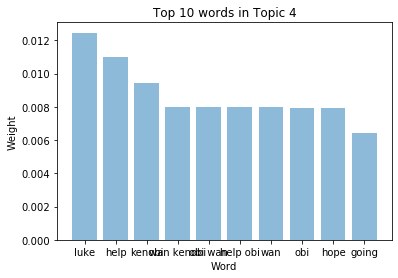

['luke', 'help', 'kenobi', 'wan kenobi', 'obi wan', 'help obi', 'wan', 'obi', 'hope', 'going']


In [15]:
for character in character_names:
    cv_lda_gensim(characters_dict[character], character)

***
### CV & LDA
- via sklearn
- using kmean clusturing 

In [16]:
def cv_lda_sklearn(text, character):
    print('\n\n')
    print('-------------------------------------- CV and LDA topics for ' + character + ' ----------------------------------------------' )
    
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words) 
    #, token_pattern="\\b[a-z][a-z]+\\b", tokenizer=tokenize_and_lem,)
    # max_df=0.9, min_df=0.05,
    data_vectorized = vectorizer.fit_transform(text)

    #data_vectorized = vectorizer.fit_transform(texts)

    lda_model = LatentDirichletAllocation(n_components=11, # Number of topics
                                          learning_method='online',
                                          random_state=0,       
                                          n_jobs = -1  # Use all available CPUs
                                         )

    lda_output = lda_model.fit_transform(data_vectorized)
    
    #pyLDAvis.enable_notebook()
    #prepared = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    #pyLDAvis.display(prepared)
    
    terms = vectorizer.get_feature_names()
    
    num_clusters = 5
    km_lda = KMeans(n_clusters=num_clusters)

    km_lda.fit(data_vectorized)
    clusters = km_lda.labels_.tolist()
    
    all_text = {'text': text,  'cluster': clusters}
    frame = pd.DataFrame(all_text, index = [clusters] , columns = ['text', 'cluster'])
    
    
    print("Top terms per cluster:")
    print()
    order_centroids = km_lda.cluster_centers_.argsort()[:, ::-1]

    for i in range(num_clusters):
        print('Cluster %d:' % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind]),
        print
        
        print("Cluster %d text:" % i, end='')
        for title in frame.ix[i]['text'].values.tolist():
            print(' %s,' % title, end='')
        print('\n')
        

In [17]:
for character in character_names:
    cv_lda_sklearn(characters_dict[character], character)




-------------------------------------- CV and LDA topics for Obi-Wan ----------------------------------------------
Top terms per cluster:

Cluster 0:
 wa
 tension council
 clear listen
 tension
 listen walked
 listen
 wa clear
 walked right
 walked
 chancellor wa
Cluster 0 text: i warned you there wa tension between the council and the chancellor i wa very clear why did not you listen you walked right into it,

Cluster 1:
 became
 wa
 politically
 powerful
 leia
 path
 foster
 course
 cell alliance
 immunity
Cluster 1 text: the organon household wa high-born and politically quite powerful in that system leia became a princess by virtue of lineage no one knew she would been adopted of course but it wa a title without real power since alderaan had long been a democracy even so the family continued to be politically powerful and leia following in her foster father 's path became a senator a well that is not all she became of course she became the leader of her cell in the alliance aga

Top terms per cluster:

Cluster 0:
 master
 emperor
 wan
 obi wan
 ship
 obi
 force
 ha
 rebel
 skywalker
Cluster 0 text: where are those transmission you intercepted, if this is a consular ship where is the ambassador, commander tear this ship apart until you have found those plan and bring me the ambassador i want her alive, you are a part of the rebel alliance and a traitor take her away, i have traced the rebel spy to her now she is my only link to find their secret base, leave that to me send a distress signal and then inform the senate that all aboard were killed, she must have hidden the plan in the escape pod send a detachment down to retrieve them see to it personally commander there 'll be no one to stop u this time, the plan you refer to will soon be back in our hand, do not be too proud of this technological terror you have constructed the ability to destroy a planet is insignificant next to the power of the force, i find your lack of faith disturbing, a you wish, and now y

Top terms per cluster:

Cluster 0:
 uncle
 owen
 uncle owen
 wa
 well
 pretty
 going
 come
 really blow
 wa busted
Cluster 0 text: so i cut off my power shut down the afterburner and came in low on deak 's trail i wa so close i thought i wa going to fry my instrument a it wa i busted up the skyhopper pretty bad uncle owen wa pretty upset he grounded me for the rest of the season you should have been there it wa fantastic, look who is talking now that you have been around those giant starship you are beginning to sound like my uncle you have gotten soft in the city, uncle owen, uncle owen, old ben kenobi life out in this direction somewhere but i do not see how that r2 unit could have come this far we must have missed him uncle owen is not going to take this very well, well come on it is getting late i only hope we can get back before uncle owen really blow up, i think my uncle knew him he said he wa dead, uncle owen aunt beru uncle owen,

Cluster 1:
 know
 right
 going
 get
 artoo
 com

Top terms per cluster:

Cluster 0:
 oh
 oh oh
 master
 oh dear
 dear
 master luke
 luke
 message
 dear oh
 goodness
Cluster 0 text: he say he is the property of obi-wan kenobi a resident of these part and it is a private message for him quite frankly sir i do not know what he is talking about our last master wa captain antilles but with what we have been through this little r2 unit ha become a bit eccentric, actually artoo ha been known to make mistake from time to time oh dear oh dear do not worry about master luke i am sure he will be all right he is quite clever you know for a human being, artoo you take good care of master luke now understand and do take care of yourself oh dear oh dear, oh yes that is very good i like that oh something 's not right because now i can not see wait wait oh my what have you done i am backwards you stupid furball only an overgrown mophead like you would be stupid enough, just you deliver master luke 's message and get u out of here oh my oh oh no, oh m

Top terms per cluster:

Cluster 0:
 ship
 get
 take
 thousand
 leave
 coming
 ready
 fast
 really
 get back
Cluster 0 text: fast ship you have never heard of the millennium falcon, it is the ship that made the kessel run in le than twelve parsec, i 've outrun imperial starship not the local bulk-cruisers mind you i am talking about the big corellian ship now she is fast enough for you old man what is the cargo, okay you guy got yourself a ship we will leave a soon a you are ready docking bay ninety-four, seventeen thousand those guy must really be desperate this could really save my neck get back to the ship and get her ready, the entire starfleet could not destroy the whole planet it had take a thousand ship with more fire power than i 've, there is another ship coming in, get back to the ship, we are coming up on the sentry ship hold 'em off angle the deflector shield while i charge up the main gun, not this ship sister, do not worry i will leave first i am going to get you to your s

Top terms per cluster:

Cluster 0:
 anakin
 wa
 jedi
 know
 annie
 love
 like
 going
 would
 could
Cluster 0 text: we are brave your highness, that is all right, thank you this little guy is quite a mess, i am padme i attend her highness you are a gungan are not you how did you end up here with u, i 've been trained in defense i can take care of myself, .like u jar jar is in a constant state of panic, what, i 've never heard of angel, you are a funny little boy how do you know so much, you are a slave, i am sorry i do not fully understand this is a strange world to me, i am glad i met you .ah, anakin, padme naberrie, and that work for you, on the outskirt, and our droid artoo-detoo, he is wonderful, he is perfect, i can not believe there is still slavery in the galaxy the republic 's anti-slavery law, our ship wa damaged and we are stranded here until we can repair it, these junk dealer must have a weakness of some kind, i am sure qui-gon doe not want to put your son in danger we will 

Top terms per cluster:

Cluster 0:
 dark
 side
 dark side
 force
 flow
 fear aggression
 jedi strength
 flow force
 dominate destiny
 strength
Cluster 0 text: run yes a jedi 's strength flow from the force but beware of the dark side anger fear aggression the dark side of the force are they easily they flow quick to join you in a fight if once you start down the dark path forever will it dominate your destiny consume you it will a it did obi-wan 's apprentice, remember a jedi 's strength flow from the force but beware anger fear aggression the dark side are they once you start down the dark path forever will it dominate your destiny, and only those who have turned to the dark side can sense the possibility of the future only going through the dark side can we see,

Cluster 1:
 must
 force
 much
 yes
 dark
 master
 good
 strong
 see
 old
Cluster 1 text: hmmm much anger in him like his father, hah he is not ready, he is too old yes too old to begin the training, will he finished what he 

Top terms per cluster:

Cluster 0:
 master
 jedi
 going
 know
 wa
 artoo
 right
 mom
 think
 one
Cluster 0 text: now go my son leave me, you already have luke you were right about me tell your sister you were right, mel tassa cho-passa, are you an angel, an angel i 've heard the deep space pilot talk about them they live on the moon of iego i thimk they are the most beautiful creature in the universe they are good and kind and so pretty they make even the most hardened spice pirate cry, you must be one maybe you just do not know it, since i wa very little three i think my mom and i were sold to gardulla the hutt but she lost u betting on the podraces to watto who is a lot better master than gardulla i think, i am a person my name is anakin, you are a strange girl to me, hit the nose, would not have lasted long if i were not so good at fixing thing i am making my own droid, anakin, anakin skywalker, i am glad i met you too, la lova num botaffa, because you are afraid, chess ko sebulba c

Top terms per cluster:

Cluster 0:
 luke
 know
 get
 come
 going
 got
 wa
 need
 han
 like
Cluster 0 text: i do not know what you are talking about i am a member of the imperial senate on a diplomatic mission to alderaan, help me obi-wan kenobi you aremy only hope, help me obi-wan kenobi, governor tarkin i should have expected to find you holding vader 's leash i recognized your foul stench when i wa brought on board, to take the responsibility yourself, the more you tighten your grip tarkin the more star system will slip through your finger, no alderaan is peaceful we have no weapon you can not possibly, dantooine, they are on dantooine, what, no, are not you a little short for a stormtrooper, you are who, ben kenobi is here where is he, look like you managed to cut off our only escape route, this is some rescue when you came in here did not you have a plan for getting out, somebody ha to save our skin into the garbage chute wise guy, put that thing away you are going to get u all kil

***
### CV & LDA
- via sklearn
- grouping with topics

In [39]:
def cv_lda(text, character):
    print('\n\n')
    print('-------------------------------------- CV and LDA topics for ' + character + ' ----------------------------------------------' )
    
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)
    #, tokenizer=tokenize_and_lem)
    #token_pattern="\\b[a-z][a-z]+\\b")
    # max_df=0.9, min_df=0.05,
    data_vectorized = vectorizer.fit_transform(text)

    lda_model = LatentDirichletAllocation(n_components=8, # Number of topics
                                          learning_method='online',
                                          random_state=0,       
                                          n_jobs = -1  # Use all available CPUs
                                         )

    lda_output = lda_model.fit_transform(data_vectorized)
    
    
    def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
        keywords = np.array(vectorizer.get_feature_names())
        topic_keywords = []
        for topic_weights in lda_model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:n_words]
            topic_keywords.append(keywords.take(top_keyword_locs))
        return topic_keywords

    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)

    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    
    df_clean = pd.DataFrame(text)
    df_clean.columns = ['text']

    # Create Document - Topic Matrix
    lda_output = lda_model.transform(data_vectorized)
    # column names
    topicnames = df_topic_keywords.T.columns
    # index names
    docnames = ["Doc" + str(i) for i in range(len(df_clean))]
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    df_document_topic.reset_index(inplace=True)
    df_sent_topic= pd.merge(df_clean, df_document_topic, left_index=True, right_index=True)
    df_sent_topic.drop('index', axis=1, inplace=True)
    df_topic_theme = df_sent_topic[['text', 'dominant_topic']]
    df_topic_theme['character'] = character
    from IPython.display import display
    display(df_topic_theme)
    #return df_topic_theme


    pyLDAvis.enable_notebook()
    prepared = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return df_topic_theme, prepared

In [40]:
columns = ['text', 'dominant_topic', 'character']
character_topics_df = pd.DataFrame(columns=columns)
prepared_dict = {}
for character in character_names:
    df, prepared = cv_lda(characters_dict[character], character)
    character_topics_df = character_topics_df.append(df, ignore_index=True)
    prepared_dict[character] = prepared 




-------------------------------------- CV and LDA topics for Obi-Wan ----------------------------------------------


text  dominant_topic  \
0    Hello there!  Come here my little friend.  Don...               3   
1                     Don't worry, he'll be all right.               3   
2    Rest easy, son, you've had a busy day.  You're...               2   
3    The Jundland Wastes are not to be traveled lig...               0   
4    Obi-Wan Kenobi... Obi-Wan?  Now thats a name I...               2   
..                                                 ...             ...   
584  I will take the child and watch over him. Mast...               1   
585                                         Training??               6   
586                                               Who?               0   
587        Qui-Gon? But, how could he accomplish this?               1   
588                   I will be able to talk with him?               4   

    character  
0     Obi-Wan  
1     Obi-Wan  
2     Obi-Wan  
3     Obi-Wan  
4     Obi-Wan  
..        ...  
584   Obi-Wan  
585   Obi-Wan  
586   Obi-Wan  
587   Obi-Wan  
588   Obi-Wan  

[589 rows x 3 columns]




-------------------------------------- CV and LDA topics for Vader ----------------------------------------------


text  dominant_topic  \
0       Where are those transmissions you intercepted?               7   
1    If this is a consular ship... where is the Amb...               1   
2    Commander, tear this ship apart until you've f...               1   
3    Don't play games with me, Your Highness.  You ...               1   
4    You're a part of the Rebel Alliance... and a t...               2   
..                                                 ...             ...   
140      The Separatists are taken care of, My Master.               5   
141                              Thank you, My Master.               5   
142                                Very good, My Lord.               2   
143  (continuing) Where is Padme? Is she safe, is s...               1   
144  I couldn't have! She was alive! I felt her! Sh...               1   

    character  
0       Vader  
1       Vader  
2       Vader  
3       Vader  
4       Vader  
..        ...  
140     Vader  
141     Vader  
142     Vader  
143     Vader  
144     Vader  

[145 rows x 3 columns]




-------------------------------------- CV and LDA topics for Luke ----------------------------------------------


text  dominant_topic  \
0    Hurry up!  Come with me!  What are you waiting...               0   
1                     Shape it up you guys!...  Biggs?               5   
2    I didn't know you were back!  When did you get...               0   
3    The Academy didn't change you much... but you'...               2   
4    I almost forgot.  There's a battle going on!  ...               3   
..                                                 ...             ...   
489                                         Never-r-r!               2   
490  Never! I'll never turn to the dark side. You'v...               2   
491                           Father, please. Help me.               3   
492  No. You're coming with me. I can't leave you h...               1   
493                       Father... I won't leave you.               0   

    character  
0        Luke  
1        Luke  
2        Luke  
3        Luke  
4        Luke  
..        ...  
489      Luke  
490      Luke  
491      Luke  
492      Luke  
493      Luke  

[494 rows x 3 columns]




-------------------------------------- CV and LDA topics for C-3PO ----------------------------------------------


text  dominant_topic  \
0    Did you hear that?  They've shut down the main...               2   
1                                        We're doomed!               7   
2    There'll be no escape for the Princess this time.               4   
3                                         What's that?               0   
4    I should have known better than to trust the l...               4   
..                                                 ...             ...   
353  What are you doing? You're going to hurt her. ...               0   
354  I am being careful. I've got a good hold on he...               7   
355  Master Kenobi! We have Miss Padme on board. Pl...               2   
356   It s some kind of reproductive process, I think.               3   
357                                            Oh, no.               7   

    character  
0       C-3PO  
1       C-3PO  
2       C-3PO  
3       C-3PO  
4       C-3PO  
..        ...  
353     C-3PO  
354     C-3PO  
355     C-3PO  
356     C-3PO  
357     C-3PO  

[358 rows x 3 columns]




-------------------------------------- CV and LDA topics for Han ----------------------------------------------


text  dominant_topic  \
0    Han Solo.  I'm captain of the Millennium Falco...               3   
1    Fast ship?  You've never heard of the Millenni...               7   
2    It's the ship that made the Kessel run in less...               1   
3    I've outrun Imperial starships, not the local ...               2   
4             What is it?  Some kind of local trouble?               0   
..                                                 ...             ...   
454                                         Stay back.               1   
455  Chewie!  Get down here!  She's wounded!  No, w...               1   
456                           Throw me another charge.               6   
457                                        Move! Move!               2   
458                                           Lando...               3   

    character  
0         Han  
1         Han  
2         Han  
3         Han  
4         Han  
..        ...  
454       Han  
455       Han  
456       Han  
457       Han  
458       Han  

[459 rows x 3 columns]




-------------------------------------- CV and LDA topics for Padme ----------------------------------------------


text  dominant_topic  \
0                         We are brave, Your Highness.               0   
1                                    That's all right.               3   
2          Thank you. This little guy is quite a mess.               2   
3    I'm Padme, I attend Her Highness, You're a Gun...               2   
4    I've been trained in defense... I can take car...               7   
..                                                 ...             ...   
351                      Obi-Wan? Is Anakin all right?               3   
352                                         Luke . . .               5   
353                                        . . . Leia.               4   
354                                      I can't . . .               0   
355  Obi-Wan . . . there . . . is good in him. I kn...               3   

    character  
0       Padme  
1       Padme  
2       Padme  
3       Padme  
4       Padme  
..        ...  
351     Padme  
352     Padme  
353     Padme  
354     Padme  
355     Padme  

[356 rows x 3 columns]




-------------------------------------- CV and LDA topics for Yoda ----------------------------------------------


text  dominant_topic  \
0            Hmmm. Much anger in him, like his father.               6   
1                                Hah. He is not ready.               1   
2    Ready, are you? What know you of ready? For ei...               5   
3    He is too old. Yes, too old to begin the train...               2   
4                     Will he finished what he begins?               4   
..                                                 ...             ...   
163  (continuing) Master Kenobi, wait a moment. In ...               0   
164  An old friend has learned the path to immortal...               1   
165  One who has returned from the netherworld of t...               2   
166  The secret of the Ancient Order of the Whills,...               5   
167  How to join the Force, he will train you. Your...               5   

    character  
0        Yoda  
1        Yoda  
2        Yoda  
3        Yoda  
4        Yoda  
..        ...  
163      Yoda  
164      Yoda  
165      Yoda  
166      Yoda  
167      Yoda  

[168 rows x 3 columns]




-------------------------------------- CV and LDA topics for Anakin ----------------------------------------------


text  dominant_topic  \
0                          Now...go, my son. Leave me.               5   
1    You already have, Luke. You were right about m...               0   
2    (subtitled) Mel tassa cho-passa... (I was clea...               1   
3                                    Are you an angel?               5   
4    An angel. I've heard the deep space pilots tal...               5   
..                                                 ...             ...   
687  I should have known the Jedi were plotting to ...               7   
688  From the Jedi point of view! From my point of ...               7   
689  This is the end for you, My Master. I wish it ...               4   
690                        You underestimate my power!               4   
691                                        I hate you!               3   

    character  
0      Anakin  
1      Anakin  
2      Anakin  
3      Anakin  
4      Anakin  
..        ...  
687    Anakin  
688    Anakin  
689    Anakin  
690    Anakin  
691    Anakin  

[692 rows x 3 columns]




-------------------------------------- CV and LDA topics for Leia ----------------------------------------------


text  dominant_topic  \
0    Lord Vader, I should have known.  Only you cou...               7   
1    I don't know what you're talking about.  I'm a...               5   
2        Help me, Obi-Wan Kenobi.  You'remy only hope.               2   
3    Help me, Obi-Wan Kenobi.  You're my only hope....               2   
4                           Help me, Obi-Wan Kenobi...               2   
..                                                 ...             ...   
222                 The code's changed. We need Artoo!               3   
223  Artoo, where are you? We need you at the bunke...               5   
224                                    I'll cover you.               3   
225                                      It's not bad.               1   
226                                            I know.               5   

    character  
0        Leia  
1        Leia  
2        Leia  
3        Leia  
4        Leia  
..        ...  
222      Leia  
223      Leia  
224      Leia  
225      Leia  
226      Leia  

[227 rows x 3 columns]

In [41]:
character_topics_df

text dominant_topic  \
0     Hello there!  Come here my little friend.  Don...              3   
1                      Don't worry, he'll be all right.              3   
2     Rest easy, son, you've had a busy day.  You're...              2   
3     The Jundland Wastes are not to be traveled lig...              0   
4     Obi-Wan Kenobi... Obi-Wan?  Now thats a name I...              2   
...                                                 ...            ...   
3483                 The code's changed. We need Artoo!              3   
3484  Artoo, where are you? We need you at the bunke...              5   
3485                                    I'll cover you.              3   
3486                                      It's not bad.              1   
3487                                            I know.              5   

     character  
0      Obi-Wan  
1      Obi-Wan  
2      Obi-Wan  
3      Obi-Wan  
4      Obi-Wan  
...        ...  
3483      Leia  
3484      Leia  
3485      Leia  
3486      Leia  
3487      Leia  

[3488 rows x 3 columns]

In [42]:
character_topics_df.to_csv('character_topics.csv')

In [43]:
print('Topics for Obi-Wan')
pyLDAvis.display(prepared_dict['Obi-Wan'])

Topics for Obi-Wan


In [44]:
print('Topics for Vader')
pyLDAvis.display(prepared_dict['Vader'])

Topics for Vader


In [45]:
print('Topics for C-3PO')
pyLDAvis.display(prepared_dict['C-3PO'])

Topics for C-3PO


In [46]:
print('Topics for Han')
pyLDAvis.display(prepared_dict['Han'])

Topics for Han


In [47]:
print('Topics for Padme')
pyLDAvis.display(prepared_dict['Padme'])

Topics for Padme


In [48]:
print('Topics for Yoda')
pyLDAvis.display(prepared_dict['Yoda'])

Topics for Yoda


In [49]:
print('Topics for Anakin')
pyLDAvis.display(prepared_dict['Anakin'])

Topics for Anakin


In [50]:
print('Topics for Leia')
pyLDAvis.display(prepared_dict['Leia'])

Topics for Leia


## Top topics for each movie?
- or simiilarity between characters for diff movies?

In [105]:
db = client.starwars

movies = db.movies
df_movies = pd.DataFrame(list(movies.find()))
df_movies = df_movies.drop(columns = ['_id'])

In [113]:
df_movies.dtypes

character    object
dialogue     object
movie        object
dtype: object

In [115]:
pdList = [obi_wan, vader, luke, c_3po, padme, yoda, anakin, leia]
obi_wan = df_movies.loc[df_movies['character'] == 'OBI-WAN']
vader = df_movies.loc[df_movies['character'] == 'VADER']
luke = df_movies.loc[df_movies['character'] == 'LUKE']
c_3po = df_movies.loc[df_movies['character'] == 'C-3PO']
padme = df_movies.loc[df_movies['character'] == 'PADME']
yoda = df_movies.loc[df_movies['character'] == 'YODA']
anakin = df_movies.loc[df_movies['character'] == 'ANAKIN']
leia = df_movies.loc[df_movies['character'] == 'LEIA']
df_movies = pd.concat(pdList)

In [123]:
df_movies

character                                           dialogue movie
229    OBI-WAN  Hello there!  Come here my little friend.  Don...    IV
230    OBI-WAN                   Don't worry, he'll be all right.    IV
232    OBI-WAN  Rest easy, son, you've had a busy day.  You're...    IV
234    OBI-WAN  The Jundland Wastes are not to be traveled lig...    IV
236    OBI-WAN  Obi-Wan Kenobi... Obi-Wan?  Now thats a name I...    IV
...        ...                                                ...   ...
2413      LEIA                 The code's changed. We need Artoo!    VI
2415      LEIA  Artoo, where are you? We need you at the bunke...    VI
2440      LEIA                                    I'll cover you.    VI
2453      LEIA                                      It's not bad.    VI
2458      LEIA                                            I know.    VI

[3029 rows x 3 columns]

In [118]:
prequels_dict = {}
originals_dict = {}
movies_dict = {}
movie_numbers = ['IV', 'V', 'VI', 'I', 'II', 'III']

In [119]:
IV_df = df_movies.loc[df_movies['movie'] == 'IV']
IV_list = IV_df['dialogue'].tolist()
clean_IV = cleaning_function(IV_list)
originals_dict['IV'] = clean_IV
movies_dict['IV'] = clean_IV

V_df = df_movies.loc[df_movies['movie'] == 'V']
V_list = V_df['dialogue'].tolist()
clean_V = cleaning_function(V_list)
originals_dict['V'] = clean_V
movies_dict['V'] = clean_V

VI_df = df_movies.loc[df_movies['movie'] == 'VI']
VI_list = VI_df['dialogue'].tolist()
clean_VI = cleaning_function(VI_list)
originals_dict['VI'] = clean_VI
movies_dict['VI'] = clean_VI

I_df = df_movies.loc[df_movies['movie'] == 'I']
I_list = I_df['dialogue'].tolist()
clean_I = cleaning_function(I_list)
prequels_dict['I'] = clean_I
movies_dict['I'] = clean_I

II_df = df_movies.loc[df_movies['movie'] == 'II']
II_list = II_df['dialogue'].tolist()
clean_II = cleaning_function(II_list)
prequels_dict['II'] = clean_II
movies_dict['II'] = clean_II

III_df = df_movies.loc[df_movies['movie'] == 'III']
III_list = III_df['dialogue'].tolist()
clean_III = cleaning_function(III_list)
prequels_dict['III'] = clean_III
movies_dict['III'] = clean_III

prequels = [I_df, II_df, III_df]
prequels_df = pd.concat(prequels)

originals = [IV_df, V_df, VI_df]
originals_df = pd.concat(originals)

In [120]:
from pprint import pprint
pprint(movies_dict)

{'I': ['i have a bad feeling about this.',
       'it is not about the mission, master, it is '
       'somethging...elsewhere...elusive.',
       'master yoda says i should be mindful of the future...',
       'yes, master...how do you think the trade viceroy will deal with the '
       "chancellor's demands?",
       "offhand, i'd say this mission is past the negotiaion stage.",
       'they have shield generators!',
       'it is an invisible army.',
       'you were right about one thing, master. the negotiations were short.',
       'sorry, master, the water fried my weapon.',
       'yes, master.',
       'what is this?',
       'when they find us, they will crush us, grind us into little pieces, '
       'then blast us into oblivion!',
       'do not worry, this has not been our day for warm welcomes.',
       'after those droids take control of the surface, they will come here '
       'and take control of you.',
       'you and the naboo form a symbiont circle. what happens to

         'not fit? why would anyone think that?',
         'that is ridiculous. who?!?',
         'that is impossible. i would know.',
         "i sense someone familiar . . . obi-wan's been here, has not he?",
         'what did he want?',
         'you told him about us, did not you?',
         'and he is not?',
         'i am not moody . . .',
         'i do not know ... i feel . . . lost.',
         'obi-wan and the council do not trust me.',
         "something's happening . . . i am not the jedi i should be. i am one "
         'of the most powerful jedi, but i am not satisfied ... i want more, '
         'and i know i should not.',
         'i have found a way to save you.',
         'from my nightmares.',
         'i will not lose you, padme.',
         'no, i promise you! i am becoming so powerful with my new knowledge '
         'of the force, i will be able to keep you from dying.',
         'what do you mean?',
         'surely senator amidala can be trusted . . .',
       

        'they are coming in too fast!',
        'got him!  i got him!',
        'that is it!  we did it!',
        'i care!',
        'so... what do you think of her, han?',
        'good...',
        'no!',
        'it is not impossible.  i used to bullseye womp rats in my t-sixteen '
        'back home.  they are not much bigger than two meters.',
        'so... you got your reward and you are just leaving then?',
        'come on!  why do not you take a look around?  you know what is about '
        'to happen, what they are up against.  they could use a good pilot '
        'like you.  you are turning your back on them.',
        'all right.  well, take care of yourself, han... guess that is what '
        'you are best at, is not it?',
        'oh, it is han!  i do not know, i really thought he would change his '
        'mind. ',
        'i only wish ben were here.',
        'biggs!  of course, i will be up there with you!  listen, have i got '
        'some stories to tell...',


In [124]:
df_movies

character                                           dialogue movie
229    OBI-WAN  Hello there!  Come here my little friend.  Don...    IV
230    OBI-WAN                   Don't worry, he'll be all right.    IV
232    OBI-WAN  Rest easy, son, you've had a busy day.  You're...    IV
234    OBI-WAN  The Jundland Wastes are not to be traveled lig...    IV
236    OBI-WAN  Obi-Wan Kenobi... Obi-Wan?  Now thats a name I...    IV
...        ...                                                ...   ...
2413      LEIA                 The code's changed. We need Artoo!    VI
2415      LEIA  Artoo, where are you? We need you at the bunke...    VI
2440      LEIA                                    I'll cover you.    VI
2453      LEIA                                      It's not bad.    VI
2458      LEIA                                            I know.    VI

[3029 rows x 3 columns]

In [64]:
columns_movie = ['text', 'dominant_topic', 'movie']
movie_topics_df = pd.DataFrame(columns=columns_movie)
prepared_dict = {}
for movie in movie_numbers:
    df, prepared = cv_lda(movies_dict[movie], movie)
    movie_topics_df = movie_topics_df.append(df, ignore_index=True)
    prepared_dict[movie] = prepared 




-------------------------------------- CV and LDA topics for IV ----------------------------------------------


text  dominant_topic  \
0     Did you hear that?  They've shut down the main...               2   
1                                         We're doomed!               1   
2     There'll be no escape for the Princess this time.               1   
3                                          What's that?               0   
4     I should have known better than to trust the l...               7   
...                                                 ...             ...   
1005                                            Oh, no!               5   
1006  Oh, my!  Artoo!  Can you hear me?  Say somethi...               5   
1007               We'll get to work on him right away.               5   
1008  You must repair him!  Sir, if any of my circui...               6   
1009                                He'll be all right.               0   

     character  
0           IV  
1           IV  
2           IV  
3           IV  
4           IV  
...        ...  
1005        IV  
1006        IV  
1007        IV  
1008        IV  
1009        IV  

[1010 rows x 3 columns]




-------------------------------------- CV and LDA topics for V ----------------------------------------------


text  dominant_topic  \
0    Echo Three to Echo Seven. Han, old buddy, do y...               0   
1                      Loud and clear, kid. What's up?               3   
2    Well, I finished my circle. I don't pick up an...               4   
3    There isn't enough life on this ice cube to fi...               2   
4    Right. I'll see you shortly. There's a meteori...               0   
..                                                 ...             ...   
834  I'll meet you at the rendezvous point on  Tato...               7   
835               Princess, we'll find Han. I promise.               3   
836           Chewie, I'll be waiting for your signal.               3   
837     Take care, you two. May the Force be with you.               7   
838                                                Ow!               2   

    character  
0           V  
1           V  
2           V  
3           V  
4           V  
..        ...  
834         V  
835         V  
836         V  
837         V  
838         V  

[839 rows x 3 columns]




-------------------------------------- CV and LDA topics for VI ----------------------------------------------


text  dominant_topic  \
0    Command station, this is ST 321. Code Clearanc...               6   
1    The security deflector shield will be deactiva...               0   
2                         We're starting our approach.               6   
3    Inform the commander that Lord Vader's shuttle...               6   
4                                            Yes, sir.               7   
..                                                 ...             ...   
669       Wedge, I don't think we're going to make it.               4   
670        You'll make it. Just follow me Gold Leader.               0   
671  I promised to return his ship without a scratc...               3   
672                                           Lando...               7   
673                                       They did it!               0   

    character  
0          VI  
1          VI  
2          VI  
3          VI  
4          VI  
..        ...  
669        VI  
670        VI  
671        VI  
672        VI  
673        VI  

[674 rows x 3 columns]




-------------------------------------- CV and LDA topics for I ----------------------------------------------


text  dominant_topic  \
0                           (off screen voice) Captain.               3   
1                                             Yes, sir?               0   
2             (V.O) Tell them we wish to board at once.               4   
3                                             Yes, sir.               0   
4     (cont'd) With all due respect for the Trade Fe...               4   
...                                                 ...             ...   
1052                        What will happen to me now?               7   
1053  I am your Master now. You will become a Jedi, ...               7   
1054  There is no doubt. The mysterious warrior was ...               7   
1055  Always two there are....no more...no less. A m...               6   
1056  But which one was destroyed, the master or the...               6   

     character  
0            I  
1            I  
2            I  
3            I  
4            I  
...        ...  
1052         I  
1053         I  
1054         I  
1055         I  
1056         I  

[1057 rows x 3 columns]




-------------------------------------- CV and LDA topics for II ----------------------------------------------


text  dominant_topic  \
0    We made it. I guess I was wrong, there was no ...               2   
1                                             Cordé...               4   
2        ... I'm sorry, m'lady... I'm... not sure I...               0   
3                                 No!... No!... No!...               0   
4                         I should not have come back.               5   
..                                                 ...             ...   
877                          Where is your apprentice?               5   
878  On his way back to Naboo. He is escorting Sena...               5   
879  (continuing) I must admit without the clones, ...               0   
880                         Victory? Victory, you say?               4   
881  (continuing) Not victory, a defeat, it was... ...               3   

    character  
0          II  
1          II  
2          II  
3          II  
4          II  
..        ...  
877        II  
878        II  
879        II  
880        II  
881        II  

[882 rows x 3 columns]




-------------------------------------- CV and LDA topics for III ----------------------------------------------


text  dominant_topic  \
0     There isn't a droid made that can out fly you,...               0   
1                   Look out, four droids inbound . . .               7   
2                           We've got to split them up.               3   
3       Break left, fly through the guns on that tower.               2   
4     Easy for you to say . . . why am I always the ...               2   
...                                                 ...             ...   
1140  How to join the Force, he will train you. Your...               6   
1141                                  Captain Antilles.               7   
1142                                Yes, Your Highness.               3   
1143  I'm placing these droids in your care. Treat t...               5   
1144                                            Oh, no.               2   

     character  
0          III  
1          III  
2          III  
3          III  
4          III  
...        ...  
1140       III  
1141       III  
1142       III  
1143       III  
1144       III  

[1145 rows x 3 columns]

In [125]:
df_character_count = (df_movies.groupby(['character'],as_index=False) 
                                          .agg({'dialogue':'count'}) 
                                          .rename(columns={'dialogue':'total_lines'}))
df_character_count

character  total_lines
0    ANAKIN          692
1     C-3PO          358
2      LEIA          227
3      LUKE          494
4   OBI-WAN          589
5     PADME          356
6     VADER          145
7      YODA          168

In [127]:
df_movie_count = (df_movies.groupby(['movie'],as_index=False) 
                                          .agg({'dialogue':'count'}) 
                                          .rename(columns={'dialogue':'total_lines'}))
df_movie_count

movie  total_lines
0     I          355
1    II          569
2   III          777
3    IV          553
4     V          441
5    VI          334

In [130]:
df_character_movie_count = (df_movies.groupby(['character','movie'],as_index=False) 
                                          .agg({'dialogue':'count'}) 
                                          .rename(columns={'dialogue':'total_lines'}))
df_character_movie_count

character movie  total_lines
0     ANAKIN     I          185
1     ANAKIN    II          192
2     ANAKIN   III          313
3     ANAKIN    VI            2
4      C-3PO     I            7
5      C-3PO    II           24
6      C-3PO   III           26
7      C-3PO    IV          119
8      C-3PO     V           92
9      C-3PO    VI           90
10      LEIA    IV           57
11      LEIA     V          114
12      LEIA    VI           56
13      LUKE    IV          254
14      LUKE     V          128
15      LUKE    VI          112
16   OBI-WAN     I           73
17   OBI-WAN    II          160
18   OBI-WAN   III          241
19   OBI-WAN    IV           82
20   OBI-WAN     V           15
21   OBI-WAN    VI           18
22     PADME     I           61
23     PADME    II          164
24     PADME   III          131
25     VADER   III            5
26     VADER    IV           41
27     VADER     V           56
28     VADER    VI           43
29      YODA     I           29
30      YODA    II           29
31      YODA   III           61
32      YODA     V           36
33      YODA    VI           13

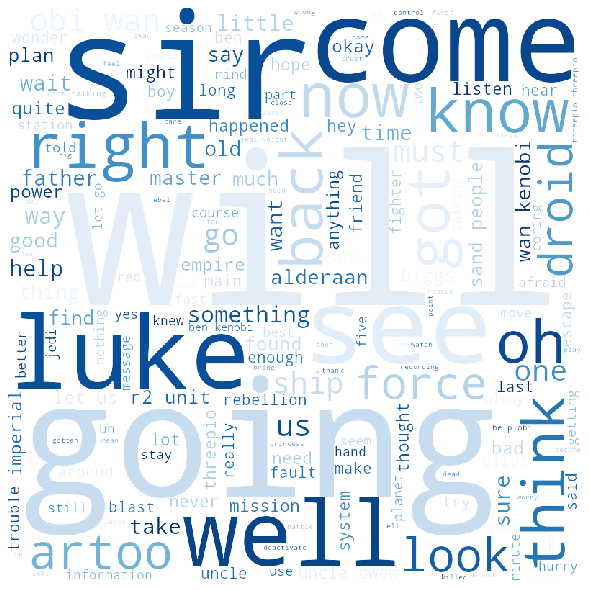

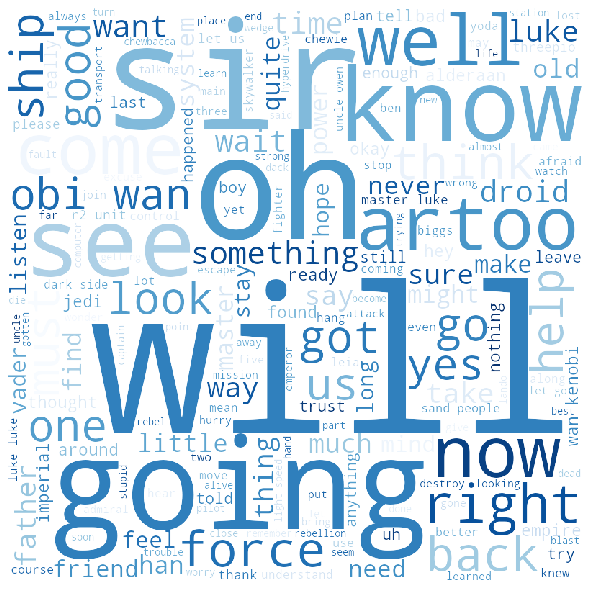

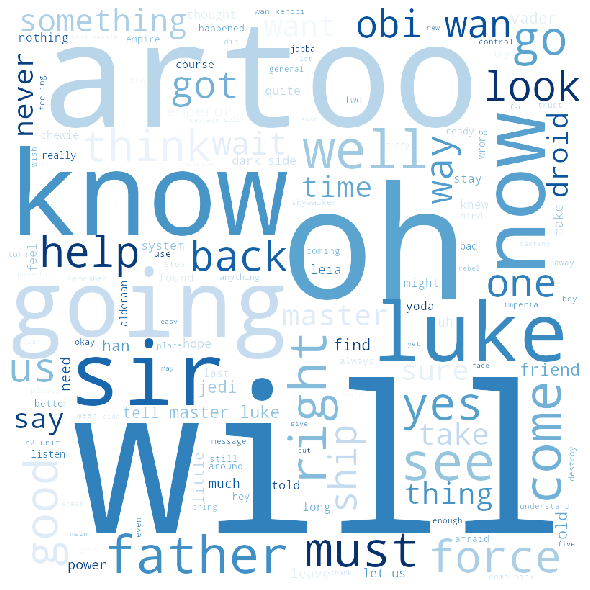

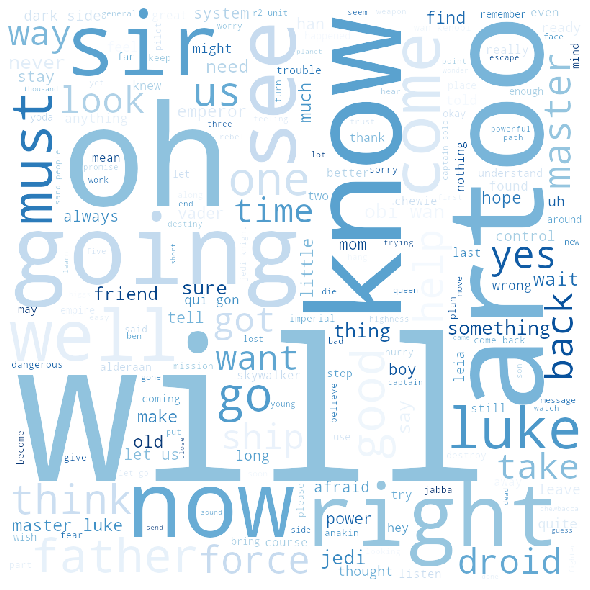

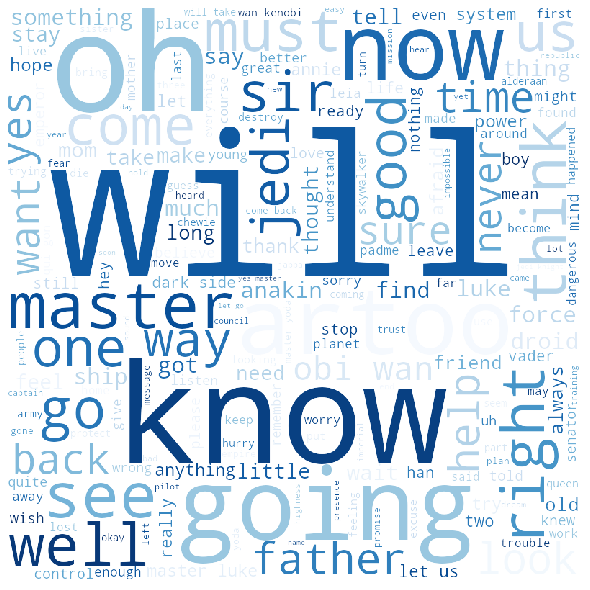

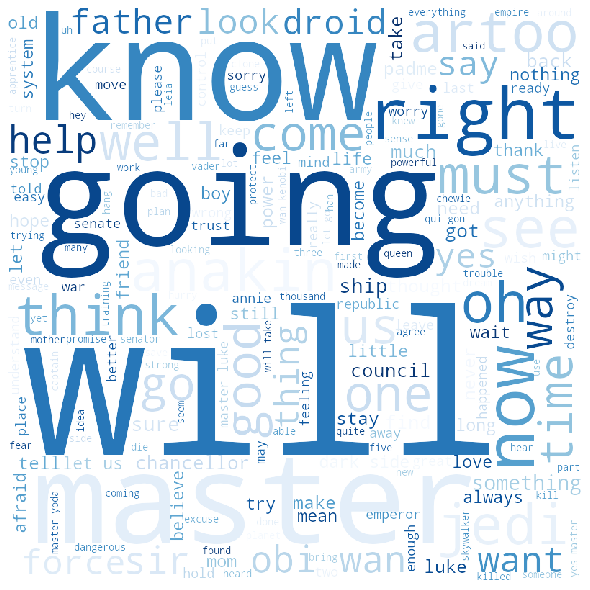

In [139]:
comment_words = ' '
stopwords = set(STOPWORDS) 

for number in movie_numbers:
    text = movies_dict[number]
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                    #background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10,
                    colormap="Blues").generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    wordcloud.to_file(number+".png")

    plt.show() 

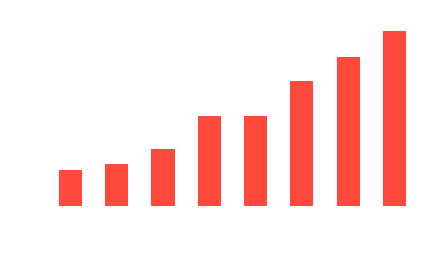

In [178]:
df = df_character_count.sort_values(by=['total_lines'])
df.plot(kind='bar',x='character',y='total_lines',color='#ff4a3b', legend=False)
plt.xlabel('Characters', color='white')
plt.ylabel('Total Lines', color='white')
plt.title('Total Lines For Characters: All Movies',color='white')
plt.tight_layout() 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines["left"].set_color("white")
ax.spines["bottom"].set_color("white")
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.savefig('character_count_all.png', dpi=1200, transparent=True)